In [1]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import os
import numpy as np
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [2]:
top_down_path = os.getcwd()
os.chdir("../Data")
data_path = os.getcwd()
os.chdir(top_down_path)

# Read data

In [3]:
# Read preprocessed
df = pd.read_csv(os.path.join(data_path, "preprocessed.csv"), index_col=0)
df.index = pd.to_datetime(df.index)

In [4]:
df[['rlm', 'slp']].mean() * 365 #/ df[['slp', 'rlm']].sum().sum()

rlm    587.060876
slp    408.409846
dtype: float64

In [5]:
df.head().transpose()

,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05
slp,2.302289,2.362777,2.284347,2.203892,2.509253
rlm,1.673442,2.056043,2.030095,2.108759,2.358004
industry,1.430437,1.645854,1.691689,1.761544,1.788436
gas_to_electricity,0.325731,0.549828,0.453608,0.465417,0.763463
electricity_from_gas,0.139161,0.234902,0.193794,0.198839,0.326173
gas_price [€/MWh],NaN,NaN,NaN,NaN,NaN
producing_sector,91.7,91.7,91.7,91.7,91.7
manufacturing_sector,94.8,94.8,94.8,94.8,94.8
hospitality_sector,82.6,82.6,82.6,82.6,82.6
retail_sector,96.1,96.1,96.1,96.1,96.1


# Prepare regression data

In [6]:
dfx = df.copy()
dfx = dfx.rename(columns={
    'aggregated': 'w2h',
    'electricity_from_gas': 'power',
    'producing_sector': 'prod',
    'manufacturing_sector': 'manu',
    'retail_sector': 'retail',
    'hospitality_sector': 'hosp',
    'gas_price [€/MWh]': 'prices'
})

dfx['log_slp'] = np.log(dfx['slp'])
dfx['log_rlm'] = np.log(dfx['rlm'])
dfx['log_industry'] = np.log(dfx['industry'])
dfx['power2'] = dfx['power'].apply(lambda x: x**2)

dfx = dfx[
    (dfx.holiday==0) & 
    (dfx.christmas_period==0) & 
    (dfx.bridgeday==0)
]

# Cut December 22-23
dfx = dfx[((dfx.index.month!=12)|(dfx.index.day<22))]

# Cut corona
# covid_beginning = "2020-02-01" --> lockdown started on 13 March 2020
#dfx = dfx[(dfx.index < '2020-03-01')|(dfx.index >= '2021-05-01')]
# invasion_date = "2022-02-24"

In [7]:
def model(dependent_variable, control_list):
    
    m = f'{dependent_variable} ~ 1 + time + C(month) + C(weekday) + ' + ' + '.join(control_list)
    print(m)
    return smf.ols(m, dfx.loc[fitting_start:]).fit(cov_type='HAC', cov_kwds={'maxlags':6})

In [8]:
def all_models(dummy_list, consumer='rlm', further_controls=False, econ=False):
    
    results = {}
    
    names = ['naive', 'temp']
    if econ:
        names += ['temp+econ']
    if consumer=='rlm':
        names += ['temp+econ+power']
    
    for name in names:
    
        control_list = [d for d in dummy_list]        
        if 'temp' in name:
            control_list += ['residential','commercial','time*residential','solar'] 
        if 'econ' in name:
            control_list += ['manu','prod'] if (consumer=='rlm' or consumer=='industry') else ['hosp','retail']
        if 'power' in name:
            control_list += ['power']
        
        results[name] = model(f'{"log_" if log else ""}{consumer}', control_list)

    return results

In [9]:
def extract_results(dummy_list, results):
    
    extracted_results = pd.concat(
        [results.params, results.bse], keys=['coef', 'se'], axis=1
    )
    
    extracted_results = extracted_results*100 if log else extracted_results
    extracted_results = extracted_results.loc[[d + '[T.True]' for d in dummy_list]]
    extracted_results.index = dummy_list
    extracted_results['low'] = extracted_results['coef'] - 2 * extracted_results['se']
    extracted_results['high'] = extracted_results['coef'] + 2 * extracted_results['se']
    
    return extracted_results

# One crisis dummy

In [10]:
def plot_waterfall(ax, results, consumer='rlm', ylabel=''):

    colors = ['tab:blue', 'tab:orange', 'tab:purple', 'tab:green', 'tab:red']
    
    for i, (name, res) in enumerate(results.items()):
        
        # first bar
        if i==0:
            ax.bar(i, res['coef'], alpha=0.5, color=colors[i])
            ax.plot([i,i], [res['low'], res['high']], color=colors[i])
        
        # waterfall
        if i > 0:
            ax.bar(i, res['coef'] - previous_coef, bottom=previous_coef, alpha=0.5, color=colors[i])    
            ax.plot([i-1.4,i+0.4], [previous_coef, previous_coef], color='black', linewidth=0.7, linestyle='--')
            ax.plot([i-0.4,i+1.4], [res['coef'], res['coef']], color='black', linewidth=0.7, linestyle='--')
            
        previous_coef = res['coef']
    
    # last bar
    i += 1
    ax.bar(i, res['coef'], alpha=0.5, color=colors[-1])
    ax.plot([i,i], [res['low'], res['high']], color=colors[-1])
    
    ax.grid(axis='y')
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_ylabel(ylabel)
    ax.set_title('Small consumers' if consumer=='slp' else 'Industrial consumers')
    if log:
        ax.set_ylim(-21, 7)
        
    labels = ['Overall\nchange', 'Temperature']
    if 'temp+econ' in results.keys():
        labels += ['Economic\nactivity']
    if consumer=='rlm': 
        labels += ['Power\nsector']
    ax.set_xticks(range(len(results)+1))
    ax.set_xticklabels((labels + ['Crisis\nresponse']))

In [11]:
def one_dummy(further_controls=False, econ=False):
    
    dummy_list=['crisis']
    dfx['crisis'] = dfx.index.map(lambda x: x >= crisis_start)

    results = {
        consumer: all_models(dummy_list, consumer, further_controls=further_controls, econ=econ) 
        for consumer in ['slp', 'industry']
    }
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4.5), sharey='row', gridspec_kw={'width_ratios': [1,1.4]})

    res = {m: extract_results(dummy_list, value) for m, value in results['slp'].items()}
    ax1 = plot_waterfall(ax1, res, 'slp', 'Estimated change in demand ' + ('(%)' if log else '(TWh/d)'))

    res = {m: extract_results(dummy_list, value) for m, value in results['industry'].items()}
    ax2 = plot_waterfall(ax2, res, 'industry')

    plt.tight_layout()
    
    return results

## Main Specification

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + manu + prod


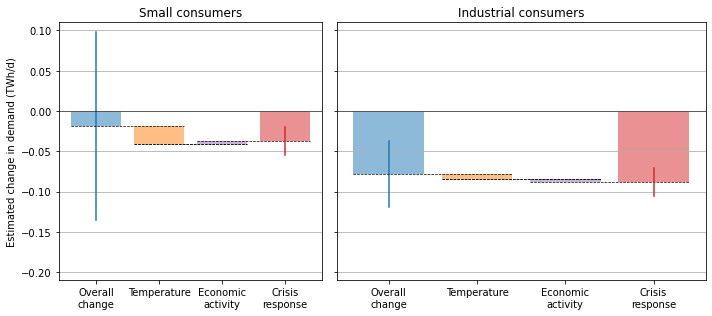

In [12]:
log=False
fitting_start = "2017-01-01"
crisis_start = "2021-08-01"
results = one_dummy(econ=True)
plt.ylim(-.21, .11)
plt.savefig(f'one_dummy.png', dpi=300)

In [13]:
results['industry']['temp+econ'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               industry   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     728.7
Date:                Tue, 05 Jul 2022   Prob (F-statistic):               0.00
Time:                        16:46:20   Log-Likelihood:                 2420.8
No. Observations:                1787   AIC:                            -4790.
Df Residuals:                    1761   BIC:                            -4647.
Df Model:                          25                                         
Covariance Type:                  HAC                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   1.0935      0.067     16.300      0.000       0.962       1.225
C(month)[T.2]              -0.0082      0.013     -0.641      0.522      -0.033       0.017
C(month)[T.3]              -0.0432      0.022     -1.941      0.052      -0.087       0.000
C(month)[T.4]              -0.0902      0.024     -3.839      0.000      -0.136      -0.044
C(month)[T.5]              -0.0790      0.025     -3.207      0.001      -0.127      -0.031
C(month)[T.6]              -0.0818      0.027     -3.039      0.002      -0.135      -0.029
C(month)[T.7]              -0.0998      0.029     -3.441      0.001      -0.157      -0.043
C(month)[T.8]              -0.1121      0.028     -3.985      0.000      -0.167      -0.057
C(month)[T.9]              -0.0793      0.027     -2.884      0.004      -0.133      -0.025
C(month)[T.10]             -0.0258      0.029     -0.896      0.371      -0.082       0.031
C(month)[T.11]             -0.0017      0.029     -0.058      0.954      -0.059       0.056
C(month)[T.12]              0.0175      0.033      0.532      0.595      -0.047       0.082
C(weekday)[T.Monday]        0.0591      0.006     10.708      0.000       0.048       0.070
C(weekday)[T.Saturday]     -0.1179      0.005    -24.110      0.000      -0.128      -0.108
C(weekday)[T.Sunday]       -0.0788      0.006    -14.287      0.000      -0.090      -0.068
C(weekday)[T.Thursday]      0.0443      0.004     10.450      0.000       0.036       0.053
C(weekday)[T.Tuesday]       0.0460      0.006      8.030      0.000       0.035       0.057
C(weekday)[T.Wednesday]     0.0507      0.005      9.959      0.000       0.041       0.061
crisis[T.True]             -0.0880      0.009     -9.940      0.000      -0.105      -0.071
time                     2.549e-05   9.99e-06      2.551      0.011     5.9e-06    4.51e-05
residential                 0.2033      0.070      2.923      0.003       0.067       0.340
commercial                  0.4357      0.137      3.174      0.002       0.167       0.705
time:residential         4.462e-06   9.81e-06      0.455      0.649   -1.48e-05    2.37e-05
solar                      -0.2939      0.052     -5.677      0.000      -0.395      -0.192
manu                        0.0072      0.004      1.722      0.085      -0.001       0.015
prod                       -0.0077      0.005     -1.626      0.104      -0.017       0.002
==============================================================================
Omnibus:                       23.431   Durbin-Watson:                   0.911
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.391
Skew:                           0.176   Prob(JB):                     2.52e-07
Kurtosis:                       3.533   Cond. No.                     1.37e+05
====================

In [14]:
# all data
#ref = dfx[(dfx.index < crisis_start) & (dfx.index.month.isin([8,9,10,11,12,1,2,3]))]['rlm'].mean()

# year-on-year
ref = dfx[(dfx.index >= '2020-08-01') & (dfx.index < '2021-05-01')]['rlm'].mean()  #, (338+58)/(338+141+58))
0.11 / ref

0.06101727296252804

In [15]:
{
    'overall': 0.14/ref,
    'power': 0.04/(ref * 141/(338+141+58)),
    'industry&district heating': 0.1/(ref * (338+58)/(338+141+58)),
}

{'overall': 0.07765834740685387,
 'power': 0.0845036120718957,
 'industry&district heating': 0.07522101832157382}

* Small consumers: 0.03 TWh/d is 2% of 1.3 TWh/d avg. demand during months 8-3 before crisis
* Large consumers: 0.14 TWh/d is 8% of 1.8 TWh/d avg. deamnd during months 8-3 before crisis
    * Of which industry & district heating: 0.1 TWh/d is 8% of 1.33 TWh/d avg. industrial demand during months 8-3 before crisis
    * Of which power sector: 0.04 TWh/d is 8% of 0.47 TWh/d avg. industrial demand during months 8-3 before crisis
* Overall: 0.17 TWh/d is 6% of overall demand (avg 3 TWh/d during months 8-3 before crisis)

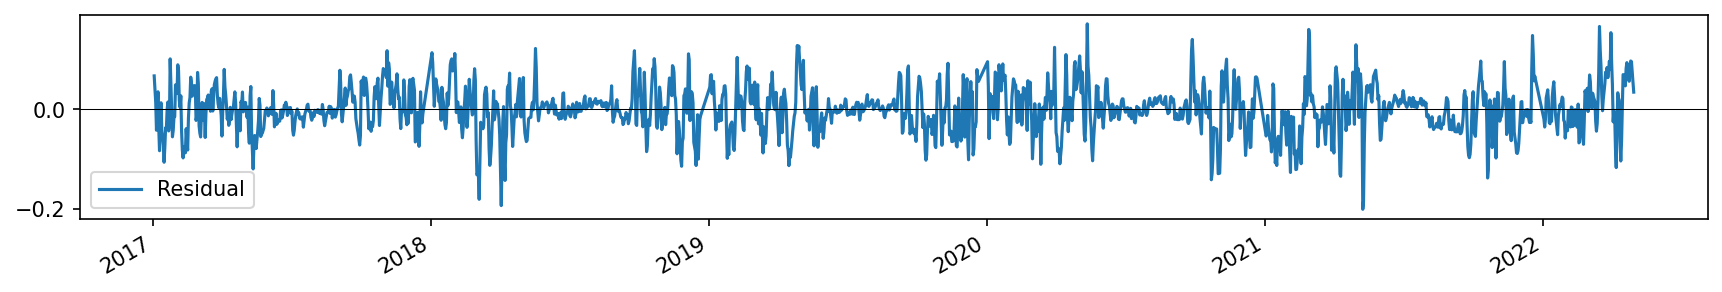

In [16]:
resid = results['slp']['temp'].fittedvalues - dfx['slp'] 

plt.figure(figsize=(14, 2), dpi=150)
#results['slp']['temp+econ'].fittedvalues.plot(label='Fitted')
#dfx['slp'].plot(label='Observed')
resid.plot(label='Residual')
plt.axhline(0, color='black', linewidth=0.5)
plt.legend()

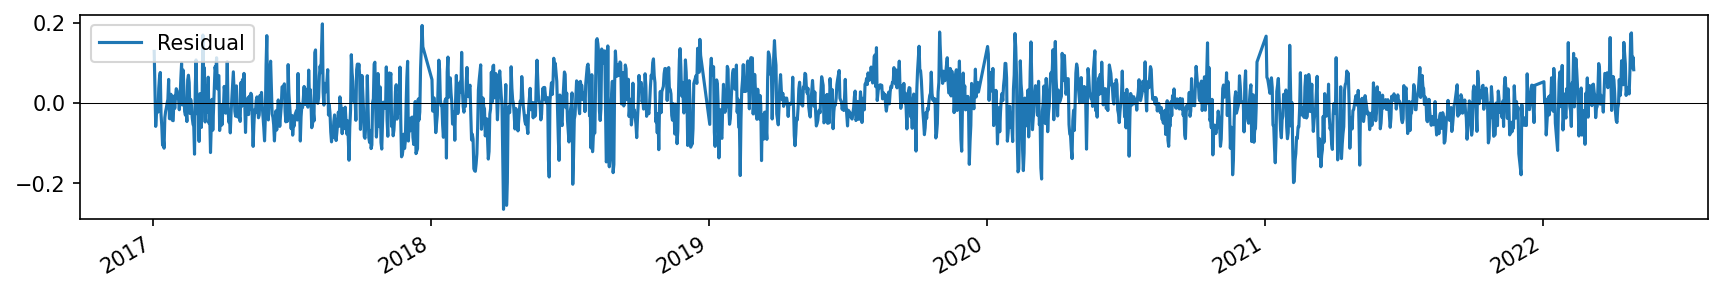

In [17]:
resid = results['industry']['temp+econ'].fittedvalues - dfx['industry'] 

plt.figure(figsize=(14, 2), dpi=150)
#results['rlm']['temp+power+econ'].fittedvalues.plot(label='Fitted')
#dfx['rlm'].plot(label='Observed')
resid.plot(label='Residual')
plt.axhline(0, color='black', linewidth=0.5)
plt.legend(loc='upper left')

## Sensitivities

Robust to chang ein crisis start

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar


(-0.21, 0.11)

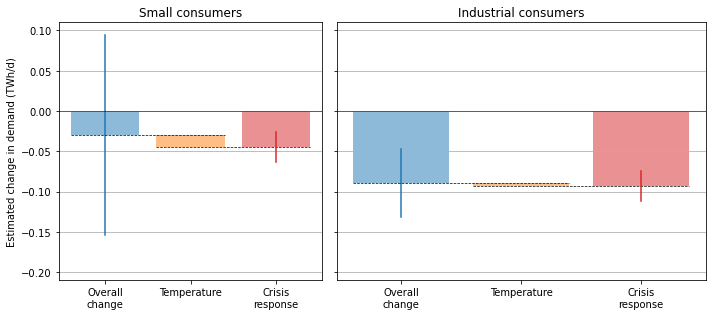

In [18]:
log=False
fitting_start = "2017-01-01"
crisis_start = "2021-09-01"
results = one_dummy()
plt.ylim(-.21, .11)

Economic activity does not change a lot

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + manu + prod


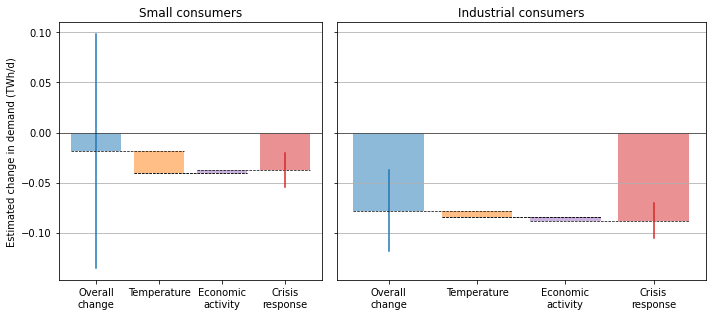

In [19]:
log=False
fitting_start = "2017-01-01"
crisis_start = "2021-08-01"
results = one_dummy(econ=True)

Logarithmic results for small consumers are very sensitive to changes in "crisis start"

log_slp ~ 1 + time + C(month) + C(weekday) + crisis
log_slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
log_slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + hosp + retail
log_industry ~ 1 + time + C(month) + C(weekday) + crisis
log_industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
log_industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + manu + prod


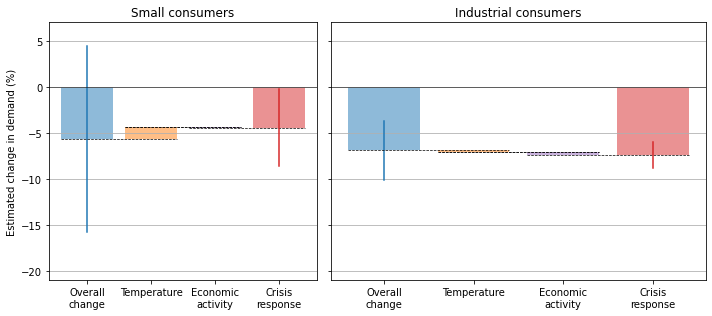

In [20]:
log=True
fitting_start = "2017-01-01"
crisis_start = "2021-09-01"
results_log = one_dummy(econ=True)

log_slp ~ 1 + time + C(month) + C(weekday) + crisis
log_slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
log_slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + hosp + retail
log_industry ~ 1 + time + C(month) + C(weekday) + crisis
log_industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
log_industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + manu + prod


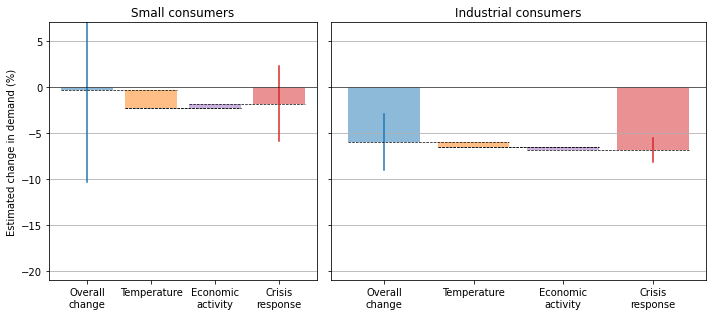

In [21]:
log=True
fitting_start = "2017-01-01"
crisis_start = "2021-08-01"
results_log = one_dummy(econ=True)

Controlling for all months that are more than 1 year previous to crisis starts makes the results insignificant and implausible

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar


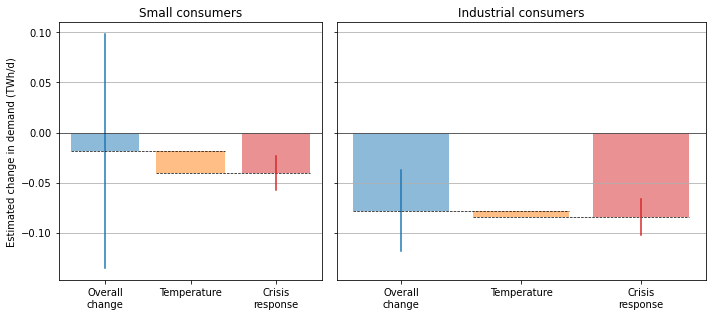

In [22]:
log=False
fitting_start = "2017-01-01"
crisis_start = "2021-08-01"
results_fc = one_dummy(further_controls=True)

# Quarterly dummies (not currently used)

In [23]:
mode = 'quarterly'
crisis_start = "2021-09-01"
dummy_list = []
for date in pd.date_range(crisis_start, '2022-04', freq='3m'):
    dummy_name = f'd{date.year}_{date.quarter}'
    dfx.loc[dfx.index, dummy_name] = dfx.index.map(
        lambda x: (x.year==date.year) & (x.quarter==date.quarter)
    ).values
    dummy_list.append(dummy_name)

# Monthly dummies

In [24]:
mode = 'monthly'
crisis_start = "2021-05-01"
dummy_list = []
for date in pd.date_range(crisis_start, '2022-05', freq='1m'):
    dummy_name = f'd{date.year}_{date.month}'
    dfx.loc[dfx.index, dummy_name] = dfx.index.map(
        lambda x: (x.year==date.year) & (x.month==date.month)
    ).values
    dummy_list.append(dummy_name)

In [25]:
def plot_monthly(ax, results, consumer='rlm', ylabel='Crisis response (TWh/d)', names=None):

    colors = {
        'naive': 'tab:blue',
        'temp+econ': ('tab:orange' if consumer=='rlm' else 'tab:red'),
        'temp+econ+power': 'tab:red'
    }
    extracted_results = {m: extract_results(dummy_list, value) for m, value in results[consumer].items()}
    
    if names==None:
        names = extracted_results.keys()
    
    for i, name in enumerate(names):
        
        res = extracted_results[name]
        
        idx = [j-0.15*(len(names)-1)+0.6/len(names)*i for j in range(len(res))]
        ax.bar(idx, res['coef'], width=0.6/len(names),alpha=0.5, label=name, color=colors[name])
        for j, d in enumerate(dummy_list):
            ax.plot([idx[j], idx[j]], [res.loc[d, 'low'], res.loc[d, 'high']], 
                     color=colors[name])
    ax.grid(axis='y')
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_ylabel(ylabel)
    ax.set_ylim(-0.2, 0.1)
    ax.set_title('Small consumers' if consumer=='slp' else 'Industrial consumers')
    if mode=='monthly':
        ax.set_xticks(
            range(len(res)), 
            [f'{date.month_name()[:3]}'+(f'\n{date.year}' if ((date.month==1) | (i==0)) else '')
             for i, date in enumerate(pd.date_range(crisis_start, '2022-05', freq='1m'))]
        )
    
    ax.axvline(7.5, color='black', linewidth=0.5)

In [29]:
log=False
results = {consumer: all_models(dummy_list, consumer, econ=True) for consumer in ['slp', 'rlm']}

slp ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4
slp ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4 + residential + commercial + time*residential + solar
slp ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4 + residential + commercial + time*residential + solar + hosp + retail
rlm ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4
rlm ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4 + residential + commercial + time*residential + solar
rlm ~ 1 + ti

TypeError: set_ticks() takes 2 positional arguments but 3 were given

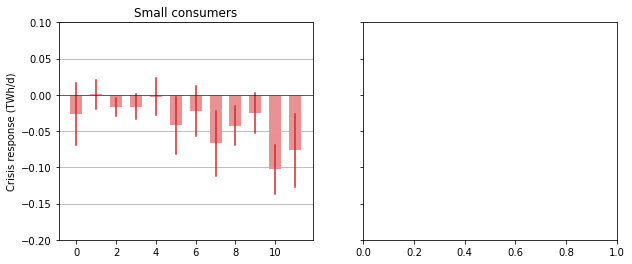

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), sharey='row', gridspec_kw={'width_ratios': [1,1]})

plot_monthly(ax1, results, 'slp', names=['temp+econ'])
#ax1.text(10.5, 0.02, 'Invasion\nof Ukraine', horizontalalignment='center')

plot_monthly(ax2, results, names=['temp+econ+power'], ylabel='')
#ax2.text(4.5, 0.02, 'TTF prices\nall-time-high', horizontalalignment='center')

plt.tight_layout()
plt.savefig('months.png')

In [ ]:
results['rlm']['temp+econ+power'].summary()

In [ ]:
0.075 / (dfx[(dfx.index.year==2022) & (dfx.index.month.isin([4]))]['slp'].mean() + 0.075)

## Augmented Dickey-Fuller test for stationarity

In [ ]:
print(adfuller(df_x_no_holiday['rlm'].dropna(), regression='nc'))

# p = 0.04910444772233917 -> we can reject the null that the process has a unit root (it can still be seasonal non-stationary, however)

print(adfuller(df_x_no_holiday['slp_w2h'].dropna(), regression='c'))

# we can only reject at 10% confidence level but this might change if bug in 2022 data is fixed

print(adfuller(df_x_no_holiday['power'].dropna(), regression='c'))

# p = 0.0011084722880644524 -> we can reject the null that the process has a unit root (it can still be seasonal non-stationary, however))

print(adfuller(df_x_no_holiday['power'].dropna(), regression='c'))

# p = 6.344246220602208e-05 -> we can reject the null that the process has a unit root (it can still be seasonal non-stationary, however)

## KPSS test for stationarity

In [ ]:
kpss(df_x_no_holiday['rlm'].dropna(), regression='c')

# p is very large -> we cannot reject the null that the process is (level) stationary (it can still be seasonal non-stationary, however)

kpss(df_x_no_holiday['w2h'].dropna(), regression='c')

# p is very large -> we cannot reject the null that the process is (level) stationary (it can still be seasonal non-stationary, however)

kpss(df_x_no_holiday['power'].dropna(), regression='c')

# p is very large -> we cannot reject the null that the process is (level) stationary (it can still be seasonal non-stationary, however)

kpss(df_x_no_holiday['econ'].dropna(), regression='c')

# p is very large -> we have to reject the null that the the process is (level) stationary
# CHECK: this is counterintuitive as the DF test finds the opposite